# GCash Topic Modeling Notebook
---

## Download and install requisite libraries and packages
---

In [1]:
import sys

!{sys.executable} -m pip install -U mxnet
!{sys.executable} -m pip install -U nltk
!{sys.executable} -m pip install -U numpy
!{sys.executable} -m pip install -U spacy
!{sys.executable} -m pip install -U pandas
!{sys.executable} -m pip install -U pillow
!{sys.executable} -m pip install -U plotly
!{sys.executable} -m pip install -U seaborn
!{sys.executable} -m pip install -U wordcloud
!{sys.executable} -m pip install -U matplotlib
!{sys.executable} -m pip install -U advertools
!{sys.executable} -m pip install -U autocorrect
!{sys.executable} -m pip install -U scikit-learn
!{sys.executable} -m pip install -U psutil requests
!{sys.executable} -m pip install -U datetime_truncate
!{sys.executable} -m pip install jupyterlab "ipywidgets>=7.5"
# !{sys.executable} -m pip install "notebook>=5.3" "ipywidgets>=7.5"

     |████████████████████████████████| 46.9 MB 111 kB/s  eta 0:00:01
     |████████████████████████████████| 1.5 MB 19.9 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 6.9 MB/s  eta 0:00:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.4.4
    Uninstalling nltk-3.4.4:
      Successfully uninstalled nltk-3.4.4
     |████████████████████████████████| 12.9 MB 23.1 MB/s eta 0:00:01
     |████████████████████████████████| 456 kB 73.4 MB/s eta 0:00:01
     |████████████████████████████████| 620 kB 51.7 MB/s eta 0:00:01
     |████████████████████████████████| 9.2 MB 66.9 MB/s eta 0:00:01
     |████████████████████████████████| 9.8 MB 57.6 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 71.7 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.6 MB/s  eta 0:00:01
     |████████████████████████████████| 113 kB 63.6 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-3.0.0-py3-none-any.whl size=107097 sha256=034

### JupyterLab renderer support
install the required JupyterLab extensions

In [2]:
!conda install -c conda-forge nodejs -y
!conda install -c plotly plotly-orca -y

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::seaborn-base==0.11.1=pyhd8ed1ab_1
  - conda-forge/noarch::nbclassic==0.2.6=pyhd8ed1ab_0
  - conda-forge/linux-64::blaze==0.11.3=py36_0
  - conda-forge/linux-64::matplotlib==3.3.4=py36h5fab9bb_0
  - defaults/linux-64::_anaconda_depends==5.1.0=py36_2
  - conda-forge/noarch::jupyterlab==3.0.9=pyhd8ed1ab_0
  - conda-forge/noarch::python-language-server==0.36.2=pyhd8ed1ab_0
  - conda-forge/noarch::jupyterlab_server==2.3.0=pyhd8ed1ab_0
  - conda-forge/noarch::pyls-black==0.4.6=pyh9f0ad1d_0
  - conda-forge/linux-64::scikit-image==0.16.2=py36hb3f55d8_0
  - conda-forge/noarch::black==20.8b1=py_1
  - conda-forge/linux-64::anyio==2.1.0=py36h5fab9bb_0
  - conda-forge/linux-64::jupyter_server==1.4.1=py36h5fab9bb_0
  - conda-forge/linux-64::bokeh==2.2.3=py36h5fab9bb_0
  - conda-forge/noarch::numpydoc==1.1.0=py_1
  - conda-forg

In [3]:
!jupyter labextension install jupyterlab-plotly

Config option `kernel_spec_manager_class` not recognized by `InstallLabExtensionApp`.
[W 2021-06-26 05:23:59.064 LabApp] Config option `kernel_spec_manager_class` not recognized by `LabApp`.
Building jupyterlab assets (production, minimized)


In [4]:
import matplotlib.pyplot as plt
import plotly.express as px
import wordcloud as wc
import seaborn as sns
import pandas as pd 
import numpy as np
import mxnet as mx
import tarfile
import zipfile
import sklearn
import os
from datetime_truncate import truncate

## Import and prepare CSV files
---

In [140]:
gps_df = pd.read_csv('data/play_store_reviews.csv')
as_df = pd.read_csv('data/app_store_reviews.csv')
combined_df = pd.read_csv('data/combined_reviews.csv')

# convert date columns to datetime since dtypes aren't preserved in csv files
gps_df['at'] = pd.to_datetime(gps_df['at'])
as_df['date'] = pd.to_datetime(as_df['date'])
combined_df['date'] = pd.to_datetime(combined_df['date'])

In [141]:
# drop unnecessary columns
gps_df = gps_df.drop(['reviewId', 'userName', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'replyContent', 'repliedAt'], axis=1)
gps_df['type'] = 'play store'

gps_df.info()
print(display(gps_df.head(10)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110606 entries, 0 to 110605
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   content  110597 non-null  object        
 1   score    110606 non-null  int64         
 2   at       110606 non-null  datetime64[ns]
 3   type     110606 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 3.4+ MB


,content,score,at,type
0,Friendly user.,5,2020-08-05 06:23:06,play store
1,nice and easy,5,2021-05-07 12:10:07,play store
2,Amazing gcash,5,2021-04-11 06:13:37,play store
3,Nice apps ever last thing 🔥🔥🔥🔥🔥😍😍😍😍😍😘😘😘😘😘,5,2021-02-26 01:45:39,play store
4,Very convinience,5,2020-08-02 04:48:25,play store
5,wow,5,2020-03-30 03:43:02,play store
6,Excellent,5,2020-10-22 15:58:33,play store
7,Kkkkkkkk,5,2020-10-25 05:57:47,play store
8,Nice,5,2021-03-06 12:42:25,play store
9,vgood,5,2021-04-06 07:14:31,play store


None


In [142]:
as_df = as_df.drop(['title', 'userName', 'isEdited', 'developerResponse'], axis=1)
as_df['type'] = 'app store'

as_df.info()
print(display(as_df.head(10)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1669 non-null   datetime64[ns]
 1   review  1669 non-null   object        
 2   rating  1669 non-null   int64         
 3   type    1669 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 52.3+ KB


,date,review,rating,type
0,2021-02-17 06:32:13,Nakakadismaya naman. Dati okay naman yung gcas...,1,app store
1,2020-03-24 03:28:48,Don’t ever put your money here! My transaction...,1,app store
2,2020-09-15 16:58:57,Best as it has no fees. Wish they had rebates ...,5,app store
3,2020-06-07 09:31:21,Gcash has been very helpful in many ways to me...,1,app store
4,2020-09-25 09:19:47,I USED METROBANK INSTAPAY TO CASH IN BUT UNTIL...,1,app store
5,2021-01-31 02:22:08,My account was charged without the transaction...,1,app store
6,2020-07-22 08:00:54,you've alway have deductions everytime we have...,1,app store
7,2020-04-20 19:30:59,So the first time I used this app they ask me ...,1,app store
8,2020-06-16 13:13:06,please fix this problem for the first time use...,1,app store
9,2020-12-09 06:42:52,I sent wrong number pls help me to refund my m...,5,app store


None


In [ ]:
# init empty DF
combined_df = pd.DataFrame()

# populate lists
date_lst = gps_df['at'].values.tolist() + as_df['date'].values.tolist()
review_lst = gps_df['content'].values.tolist() + as_df['review'].values.tolist()
rating_lst = gps_df['score'].values.tolist() + as_df['rating'].values.tolist()
type_lst = gps_df['type'].values.tolist() + as_df['type'].values.tolist()

# populate DF
combined_df['date'] = date_lst
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df['review'] = review_lst
combined_df['rating'] = rating_lst
combined_df['type'] = type_lst

# shuffle rows
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

# drop rows that have NULL entries
combined_df = combined_df.dropna()

# drop rows that have duplicates
combined_df = combined_df.drop_duplicates()

combined_df.info()
print(display(combined_df.head(10)))

### Export combined_df as CSV

In [ ]:
combined_df.to_csv('data/combined_reviews.csv', index=False)

In [5]:
combined_df = pd.read_csv('data/combined_reviews.csv')

# convert date columns to datetime since dtypes aren't preserved in csv files
combined_df['date'] = pd.to_datetime(combined_df['date'])

# create and append month column
combined_df['month'] = combined_df['date'].apply(lambda x: truncate(x, 'month').date())
combined_df['month'] = pd.to_datetime(combined_df['month'])

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112264 entries, 0 to 112263
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    112264 non-null  datetime64[ns]
 1   review  112264 non-null  object        
 2   rating  112264 non-null  int64         
 3   type    112264 non-null  object        
 4   month   112264 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 4.3+ MB


## Exploratory Data Analysis
---

In [6]:
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# set default renderer
pio.renderers.default = "iframe"

# disable false positive warning
pd.options.mode.chained_assignment = None  # default='warn'

ax_1 = combined_df.loc[(combined_df['type'] == 'play store') & (combined_df['rating'] == 1)]
ax_5 = combined_df.loc[(combined_df['type'] == 'play store') & (combined_df['rating'] == 5)]
ax_1 = ax_1.sort_values(by=['date'])
ax_5 = ax_5.sort_values(by=['date'])
ax_1['cumsum'] = ax_1['rating'].eq(1).cumsum()
ax_5['cumsum'] = ax_5['rating'].eq(5).cumsum()
ax_1_ratings = ax_1.groupby(['month', 'rating'])['review'].count().reset_index()
ax_5_ratings = ax_5.groupby(['month', 'rating'])['review'].count().reset_index()

bx_1 = combined_df.loc[(combined_df['type'] == 'app store') & (combined_df['rating'] == 1)]
bx_5 = combined_df.loc[(combined_df['type'] == 'app store') & (combined_df['rating'] == 5)]
bx_1 = bx_1.sort_values(by=['date'])
bx_5 = bx_5.sort_values(by=['date'])
bx_1['cumsum'] = bx_1['rating'].eq(1).cumsum()
bx_5['cumsum'] = bx_5['rating'].eq(5).cumsum()
bx_1_ratings = bx_1.groupby(['month', 'rating'])['review'].count().reset_index()
bx_5_ratings = bx_5.groupby(['month', 'rating'])['review'].count().reset_index()

fig = make_subplots(
    rows=3, 
    cols=2, 
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=("Play Store Review Count Over Time (01/2020 - 06/2021)", "App Store Review Count Over Time (01/2020 - 06/2021)")
)

# Play Store
fig.add_trace(
    go.Scatter(
        x=ax_1['date'],
        y=ax_1['cumsum'],
        name='1-star Play Store',
        marker=dict(color='#4c84ed')
    ),
    row=1, 
    col=1
)
fig.add_trace(
    go.Histogram(
        x=ax_1['date'],
        y=ax_1['rating'],
        name='1-star Play Store',
        marker=dict(color='#4c84ed')
    ),
    row=2, 
    col=1
)
fig.add_trace(
    go.Scatter(
        x=ax_1_ratings['month'],
        y=ax_1_ratings['review'],
        name='1-star Play Store',
        marker=dict(color='#4c84ed')
    ),
    row=3, 
    col=1
)
fig.add_trace(
    go.Scatter(
        x=ax_5['date'],
        y=ax_5['cumsum'],
        name='5-star Play Store',
        marker=dict(color='#ed4c4c')
    ),
    row=1, 
    col=1
)
fig.add_trace(
    go.Histogram(
        x=ax_5['date'],
        y=ax_5['rating'],
        name='5-star Play Store',
        marker=dict(color='#ed4c4c')
    ),
    row=2, 
    col=1
)
fig.add_trace(
    go.Scatter(
        x=ax_5_ratings['month'],
        y=ax_5_ratings['review'],
        name='5-star Play Store',
        marker=dict(color='#ed4c4c')
    ),
    row=3, 
    col=1
)

# App Store
fig.add_trace(
    go.Scatter(
        x=bx_1['date'],
        y=bx_1['cumsum'],
        name='1-star App Store',
        marker=dict(color='#4c84ed')
    ),
    row=1, 
    col=2
)
fig.add_trace(
    go.Histogram(
        x=bx_1['date'],
        y=bx_1['rating'],
        name='1-star App Store',
        marker=dict(color='#4c84ed')
    ),
    row=2, 
    col=2
)
fig.add_trace(
    go.Scatter(
        x=bx_1_ratings['month'],
        y=bx_1_ratings['review'],
        name='1-star App Store',
        marker=dict(color='#4c84ed')
    ),
    row=3, 
    col=2
)
fig.add_trace(
    go.Scatter(
        x=bx_5['date'],
        y=bx_5['cumsum'],
        name='5-star App Store',
        marker=dict(color='#ed4c4c')
    ),
    row=1, 
    col=2
)
fig.add_trace(
    go.Histogram(
        x=bx_5['date'],
        y=bx_5['rating'],
        name='5-star App Store',
        marker=dict(color='#ed4c4c')
    ),
    row=2, 
    col=2
)
fig.add_trace(
    go.Scatter(
        x=bx_5_ratings['month'],
        y=bx_5_ratings['review'],
        name='5-star App Store',
        marker=dict(color='#ed4c4c')
    ),
    row=3, 
    col=2
)

# Update yaxis properties
fig.update_yaxes(title_text="Review Count")
fig.show()

# for graph to persist outside session
# fig.show(renderer="svg", width=1750, height=800, engine='auto')

In [7]:
# init empty DF
cx = pd.DataFrame()

# Collect and store all App Store reviews in a temporary DF
cx = combined_df
cx['Review word count'] = cx['review'].str.count(' ') + 1
print(f"\nMean word count: {cx['Review word count'].mean()}")

fig = px.histogram(
    cx, 
    x='Review word count',
    color='rating',
    labels=['Word count', 'Review count'],
    title='Review Word Count of App Store and Play Store Reviews',
    barmode='group',
    width=1000, 
    height=500
)
fig.show()

# for graph to persist outside session
# fig.show(renderer="png")


Mean word count: 8.828484643340698


### Play Store

In [10]:
# init empty DF
ax = pd.DataFrame()

# Collect and store all Play Store reviews in a temporary DF
# ax = combined_df.loc[(combined_df['type'] == 'play store') & (combined_df['date'] >= '2021-04-09 00:00:00') & (combined_df['date'] <= '2021-04-12 00:00:00')]
ax = combined_df.loc[(combined_df['type'] == 'play store')]
ax['Review word count'] = ax['review'].str.count(' ') + 1

ax_1['Review word count'] = ax_1['review'].str.count(' ') + 1
ax_5['Review word count'] = ax_5['review'].str.count(' ') + 1
print(f"Play Store reviews mean word count: {ax['Review word count'].mean()}")
print(f"\n1-star reviews mean word count: {ax_1['Review word count'].mean()}")
print(f"5-star reviews mean word count: {ax_5['Review word count'].mean()}")

fig = px.histogram(
    ax, 
    x='Review word count',
    color='rating',
    labels=['Word count', 'Review count'],
    title='Review Word Count of Play Store Reviews',
    barmode='group',
    width=1000, 
    height=500
)
fig.show()

# for graph to persist outside session
# fig.show(renderer="png")

Play Store reviews mean word count: 8.428952484289525

1-star reviews mean word count: 20.143907635214074
5-star reviews mean word count: 4.245419852011829


### App Store

In [11]:
# init empty DF
bx = pd.DataFrame()

# Collect and store all App Store reviews in a temporary DF
bx = combined_df.loc[(combined_df['type'] == 'app store')]
bx['Review word count'] = bx['review'].str.count(' ') + 1

bx_1['Review word count'] = bx_1['review'].str.count(' ') + 1
bx_5['Review word count'] = bx_5['review'].str.count(' ') + 1
print(f"App Store reviews mean word count: {bx['Review word count'].mean()}")
print(f"\n1-star reviews mean word count: {bx_1['Review word count'].mean()}")
print(f"5-star reviews mean word count: {bx_5['Review word count'].mean()}")

fig = px.histogram(
    bx, 
    x='Review word count',
    color='rating',
    labels=['Word count', 'Review count'],
    title='Review Word Count of App Store Reviews',
    barmode='group',
    width=1000, 
    height=500
)
fig.show()

# for graph to persist outside session
# fig.show(renderer="png")

App Store reviews mean word count: 35.30317555422408

1-star reviews mean word count: 35.830862533692724
5-star reviews mean word count: 31.07027027027027


## Convert plain text to bag-of-words (BOW)
---

In [309]:
import re
import nltk
import spacy 
import advertools as adv
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.corpus import wordnet, words, stopwords

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# concatenate english and tagalog stopwords into one list
stop_words = stopwords.words('english') + list(adv.stopwords['tagalog']) + \
            ['gcash', 'could', 'doe', 'might', 'must', 'need', 'sha', \
             'would', 'far', 'nag', 'already', 'always', 'app', 'cant', \
             'dont', 'even', 'get', 'please', 'say', 'still', 'try', 'use', \
             'yung', 'day', 'keep', 'lang', 'like', 'make', 'nyo', 'the', 'to', \
             'ive', 'naman', 'one', 'take', 'fully', 'also', 'app..', \
             'give', 'much', 'okay', 'pag', 'sana', 'star', 'sya', 'thank', \
             'usefull', 'verry', 'wala', 'want', 'way', 'well', 'wow', 'didnt', \
             'every', 'guy', 'hope', 'kayo', 'know', 'let', 'link', 'mag', 'many', \
             'message', 'never', 'nothing', 'open', 'put', 'really', 'seem', 'start', \
             'thing', 'whenever', 'wont', 'wrong', 'yet', 'almost', 'anymore', 'back', \
             'come', 'doesnt', 'especially', 'everytime', 'first', 'globe', 'last', \
             'month', 'new', 'niyo', 'since', 'something', 'think', 'thru', 'ung', \
             'without', 'suppose', 'tapos', 'another', 'anything', 'u', 'thats', \
             'via', 'etc', 'everything', 'everywhere', 'find', 'io', 'life', \
             'list', 'lot', 'maybe', 'meter', 'next' , 'past', 'phone', 'pls', \
             'plus', 'point', 'pwede', 'see', 'show', 'sometimes', 'team', 'whats', \
             'wish', 'year', 'gamitin', 'girl', 'hand', 'happen', 'hello', 'high', \
             'however', 'hurt', 'though', 'true', 'usually', 'screen', 'soon', 'acc', \
             'add', 'yun', 'yes', 'youre', 'coz', 'acct', 'agad', 'line', 'long', 'today', \
             'go', 'abd', 'kna', 'luv', 'kna', 'god', 'wlang', 'yeah', 'id', 'idk', 'iam', \
            'ill', 'ina', 'padin', 'kahit', 'pede', 'nang', 'supper', 'khit', 'kahit']

# Helper function to lemmatize with part of speech (POS) tag
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

token_pattern = re.compile(r"(?u)\b\w\w+\b")

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(word, get_wordnet_pos(word)) for word in word_tokenize(doc) if len(word) >= 3 and re.match("[a-z].*", word) and re.match(token_pattern, word)]

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Tokenize and lemmatize review data

In [347]:
import time
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

main_df = combined_df.loc[(combined_df['rating'] == 5) & (combined_df['type'] == 'app store')]

# split data to training (70%), validation (15%), and test (15%) datasets
train_data, val_data = train_test_split(main_df, train_size=0.7, random_state=42)
train_data, test_data = train_test_split(train_data, train_size=0.7, random_state=42) 

print(f'Training, validation, and test data shapes:\n{train_data.shape}')
print(val_data.shape)
print(test_data.shape)

first_batch = train_data.review.values.tolist()
second_batch = val_data.review.values.tolist()
third_batch = test_data.review.values.tolist()

vocab_size = 60

print('\nTokenizing and counting, this may take a few minutes...')
start_time = time.time()
vectorizer = CountVectorizer(
    input='content', 
    analyzer='word', 
    stop_words=stop_words,
    tokenizer=LemmaTokenizer(),
    strip_accents='ascii',
    max_features=vocab_size, 
    max_df=0.95, # maximum document frequency of 95% of documents
    min_df=2 # minimum document frequency of 2 documents
)

# Learn the vocabulary dictionary from the training data and return a document-term matrix
train_vectors = vectorizer.fit_transform(first_batch)
vocab_map = vectorizer.vocabulary_
vocab_list = vectorizer.get_feature_names()
removed_words = vectorizer.get_stop_words()

# Extract token counts out of validation and test datasets using the vocabulary fitted with fit 
val_vectors = vectorizer.transform(second_batch)
test_vectors = vectorizer.transform(third_batch)

print(f'\nTraining rows, vocab length:\n{train_vectors.shape}')
print('\nVocab size:', len(vocab_list))
print(f'\nVocab list:\n{vocab_list}')
print('\nDone. Time elapsed: {:.2f}s'.format(time.time() - start_time))

Training, validation, and test data shapes:
(90, 6)
(56, 6)
(39, 6)

Tokenizing and counting, this may take a few minutes...

Training rows, vocab length:
(90, 60)

Vocab size: 60

Vocab list:
['able', 'access', 'account', 'apps', 'available', 'bank', 'best', 'bill', 'buy', 'call', 'card', 'cash', 'contact', 'convenience', 'convenient', 'customer', 'data', 'date', 'different', 'easy', 'encounter', 'error', 'fast', 'fee', 'fix', 'fund', 'good', 'great', 'help', 'invest', 'issue', 'load', 'love', 'mastercard', 'money', 'number', 'online', 'pandemic', 'pay', 'payment', 'peso', 'problem', 'rebate', 'return', 'review', 'save', 'saving', 'send', 'service', 'thanks', 'time', 'transaction', 'transfer', 'update', 'useful', 'user', 'verify', 'version', 'wait', 'wallet']

Done. Time elapsed: 0.94s


### Sort mapping of terms to feature indices.

In [348]:
vocab_map_items = vocab_map.items()
sorted_vocab_items = sorted(vocab_map_items)

aux_lst = []

for i in range(len(sorted_vocab_items)):
    aux_lst.append(sorted_vocab_items[i][0])

### Store in a text file

In [349]:
with open(f'data/vocab.txt', 'w') as f:
    for item in aux_lst:
        f.write("%s\n" % item)

### Verify results
---

### Training

In [350]:
print(f'\noriginal text:')
for i in range(5):
    print(f'\n{[i]} - {train_data.review.values.tolist()[i]}')


original text:

[0] - This app is the best! Makes your life very convenient!

[1] - But what I didn’t like about this app is when you cash-in in different convenience store with a high amount of money, the deduction of it is really big and it’s really hurt. I hope it will be lessen.

[2] - The latest version and updated version of gcash is much better now! Last week i had to transfer an ample amt of cash from bank to gcash bt it did not reflect immediately. Little did i know they were having some troubleshooting on the app itself. I was downhearted. But thankgoodness! After theyre done with the updates, the cash i transferred days ago reflected right there and then. Please keep it up gcash! Continue to build upgrades so you could serve ur loyal clients at best! Stay consistent too! excited for more improvements soon. 😉

[3] - I used to think there was no point to GCash, but have discovered over the last 18 months how useful it is.

[4] - Pa verified naman ako gcash sasusunod kasi mag 

In [351]:
import random 

value = random.randrange(0, 4)
# value = 0
print(f'index: {value}')
print(f'\noriginal text:\n{train_data.review.values.tolist()[value]}')
print(f'\nvectorized text:\n{train_vectors[value].todense()}')

index: 2

original text:
The latest version and updated version of gcash is much better now! Last week i had to transfer an ample amt of cash from bank to gcash bt it did not reflect immediately. Little did i know they were having some troubleshooting on the app itself. I was downhearted. But thankgoodness! After theyre done with the updates, the cash i transferred days ago reflected right there and then. Please keep it up gcash! Continue to build upgrades so you could serve ur loyal clients at best! Stay consistent too! excited for more improvements soon. 😉

vectorized text:
[[0 0 0 0 0 1 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 2 0 0]]


In [352]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

train_counts = pd.DataFrame(
    train_vectors[:5].toarray(),
    columns=vocab_list
)

train_counts

,able,access,account,apps,available,bank,best,bill,buy,call,card,cash,contact,convenience,convenient,customer,data,date,different,easy,encounter,error,fast,fee,fix,fund,good,great,help,invest,issue,load,love,mastercard,money,number,online,pandemic,pay,payment,peso,problem,rebate,return,review,save,saving,send,service,thanks,time,transaction,transfer,update,useful,user,verify,version,wait,wallet
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,2,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0


### Validation

In [353]:
print(f'\noriginal text:')
for i in range(5):
    print(f'\n{[i]} - {val_data.review.values.tolist()[i]}')


original text:

[0] - Hello! I really enjoy using Gcash. It's so convenient. However, I just want to suggest that maybe in the future, we will be able to cash in via Gcredit or use Gcredit via Gcash mastercard. Thank you!

[1] - Finally FaceID integration. Been waiting for this.

[2] - This app is great

[3] - here for the aguinaldos lawl

[4] - it’s nice i’ve been using it for 3 years now


In [354]:
value = random.randrange(0, 4)

print(f'index: {value}')
print(f'\noriginal text:\n{val_data.review.values.tolist()[value]}')
print(f'\nvectorized text:\n{val_vectors[value].todense()}')

index: 2

original text:
This app is great

vectorized text:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [355]:
val_counts = pd.DataFrame(
    val_vectors[:5].toarray(),
    columns=vocab_list
)

val_counts

,able,access,account,apps,available,bank,best,bill,buy,call,card,cash,contact,convenience,convenient,customer,data,date,different,easy,encounter,error,fast,fee,fix,fund,good,great,help,invest,issue,load,love,mastercard,money,number,online,pandemic,pay,payment,peso,problem,rebate,return,review,save,saving,send,service,thanks,time,transaction,transfer,update,useful,user,verify,version,wait,wallet
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Type-cast input data to np.float32 since all the params (i.e. weights and biases) in the NTM model will also follow that format
This is a more optimal approach as opposed to repeatedly type-casting during mini-batch training

In [356]:
import scipy.sparse as sparse

train_vectors = sparse.csr_matrix(train_vectors, dtype=np.float32)
val_vectors = sparse.csr_matrix(val_vectors, dtype=np.float32)
test_vectors = sparse.csr_matrix(test_vectors, dtype=np.float32)

print(f'index = {value}\n')
print(type(train_vectors), train_vectors.dtype)
print(train_vectors[value])
print(type(val_vectors), val_vectors.dtype)
print(val_vectors[value])
print(type(test_vectors), test_vectors.dtype)
print(test_vectors[value])

index = 2

<class 'scipy.sparse.csr.csr_matrix'> float32
  (0, 6)	1.0
  (0, 57)	2.0
  (0, 53)	2.0
  (0, 52)	2.0
  (0, 11)	2.0
  (0, 5)	1.0
<class 'scipy.sparse.csr.csr_matrix'> float32
  (0, 27)	1.0
<class 'scipy.sparse.csr.csr_matrix'> float32
  (0, 29)	1.0
  (0, 34)	1.0
  (0, 46)	1.0
  (0, 52)	1.0


### Convert data into RecordIO Protobuf format using the SageMaker Python API and store everything in S3

In [357]:
import scipy

# convert sparse CSR matrices to numpy arrays
train_vectors = scipy.sparse.csr_matrix.toarray(train_vectors)
val_vectors = scipy.sparse.csr_matrix.toarray(val_vectors)
test_vectors = scipy.sparse.csr_matrix.toarray(test_vectors)

In [358]:
import io
import boto3
import sagemaker
import datetime as dt
import sagemaker.amazon.common as smac

sesh = sagemaker.Session()
prefix = "sagemaker/regalado"
bucket = sesh.default_bucket()
curr_dtime = time.strftime("%Y%m%d-%H%M%S")

def convAndStore(dtype, key, vectors):
    # convert data to a recordIO-wrapped protobuf format used by the Amazon SageMaker algorithms
    key = str(key)
    
    # init memory buffer in RAM where data will be written
    buf = io.BytesIO()

    # write train data (numpy array) into a dense tensor 
    # smac.write_numpy_to_dense_tensor(buf, X_train.astype("float32"), y_train.astype("float32"))
    smac.write_numpy_to_dense_tensor(buf, vectors)

    # sets the file's current position at the offset (0)
    # i.e. set the reference point to the beginning of the memory buffer
    buf.seek(0)

    # upload to s3
    boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, dtype, key)).upload_fileobj(buf)
    
    s3_data = f"s3://{bucket}/{prefix}/{dtype}/{key}"
    
    print(f"Uploaded {dtype} data at: {s3_data}")
    
    return s3_data
    
s3_train_data = convAndStore('train', curr_dtime, train_vectors)
s3_valid_data = convAndStore('valid', curr_dtime, val_vectors)
s3_test_data = convAndStore('test', curr_dtime, test_vectors)

Uploaded train data at: s3://sagemaker-us-east-1-305262579855/sagemaker/regalado/train/20210626-102121
Uploaded valid data at: s3://sagemaker-us-east-1-305262579855/sagemaker/regalado/valid/20210626-102121
Uploaded test data at: s3://sagemaker-us-east-1-305262579855/sagemaker/regalado/test/20210626-102121


### Upload vocab file to s3

In [359]:
s3_aux_path = sesh.upload_data(path=f'data/vocab.txt', key_prefix=prefix + '/input/auxiliary')
s3_aux_path

's3://sagemaker-us-east-1-305262579855/sagemaker/regalado/input/auxiliary/vocab.txt'

### Configure TrainingInput objects to use the training, validation, and test datasets that were uploaded to S3 

In [360]:
from sagemaker.session import TrainingInput

s3_train = TrainingInput(s3_train_data, distribution='FullyReplicated') # set distribution='ShardedByS3Key' if using multiple EC2 instances
s3_valid = TrainingInput(s3_valid_data) 
s3_test = TrainingInput(s3_test_data) 

## Model training
---

### Set credentials

In [361]:
from sagemaker import tuner
from sagemaker import get_execution_role
from sagemaker.image_uris import retrieve

role = get_execution_role()
region = boto3.Session().region_name    
container = retrieve('ntm', region)
client = boto3.Session().client('sagemaker')
output_prefix = os.path.join(prefix, 'output')
output_path = os.path.join('s3://', bucket, output_prefix)

2021-06-26 10:21:21,917 | INFO | image_uris.py:162 | _config_for_framework_and_scope | Same images used for training and inference. Defaulting to image scope: inference.
2021-06-26 10:21:21,918 | INFO | image_uris.py:198 | _validate_version_and_set_if_needed | Defaulting to the only supported framework/algorithm version: 1.
2021-06-26 10:21:21,930 | INFO | image_uris.py:224 | _processor | Ignoring unnecessary instance type: None.


In [362]:
!pip install 'sagemaker[local]' --upgrade

In [363]:
!sudo service docker restart

Stopping docker: [  OK  ]
Starting docker:	.[  OK  ]


### Initialize Estimator object

In [364]:
ntm = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.m4.xlarge', # Free-tier instance
    output_path=output_path,
    sagemaker_session=sesh
)

In [365]:
num_topics = 10

ntm.set_hyperparameters(
    num_topics=num_topics, 
    feature_dim=vocab_size, 
    epochs=100, 
    num_patience_epochs=5, 
    tolerance=0.001
)

## Automatic Hyperparameter Tuning
---

In [366]:
hyperparameter_ranges = {
    'weight_decay': tuner.ContinuousParameter(0.1, 1.0),
    'mini_batch_size': tuner.IntegerParameter(16, 2048),
    'learning_rate': tuner.ContinuousParameter(1e-4, 0.1),
    'rescale_gradient': tuner.ContinuousParameter(0.1, 1.0),
    'optimizer': tuner.CategoricalParameter(['sgd', 'adam', 'adadelta']),
    'encoder_layers_activation': tuner.CategoricalParameter(['sigmoid', 'tanh', 'relu'])
}

objective_metric_name = 'validation:total_loss'

In [367]:
hyperparameter_tuner = tuner.HyperparameterTuner(
    ntm,
    objective_metric_name,
    hyperparameter_ranges, 
    objective_type='Minimize',
    max_jobs=20,
    max_parallel_jobs=5
)

In [368]:
hyperparameter_tuner.fit(
    {"train": s3_train, "validation": s3_valid, "auxiliary": s3_aux_path},
    include_cls_metadata=False,
    wait=False
)

job_name = hyperparameter_tuner.latest_tuning_job.job_name

response = client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=job_name
)

response['HyperParameterTuningJobStatus']

2021-06-26 10:21:37,157 | INFO | image_uris.py:198 | _validate_version_and_set_if_needed | Defaulting to the only supported framework/algorithm version: latest.
2021-06-26 10:21:37,169 | INFO | image_uris.py:224 | _processor | Ignoring unnecessary instance type: None.
2021-06-26 10:21:37,171 | INFO | session.py:2050 | create_tuning_job | Creating hyperparameter tuning job with name: ntm-210626-1021


'InProgress'

In [369]:
from pprint import pprint

pprint(response)

{'CreationTime': datetime.datetime(2021, 6, 26, 10, 21, 37, 461000, tzinfo=tzlocal()),
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:305262579855:hyper-parameter-tuning-job/ntm-210626-1021',
 'HyperParameterTuningJobConfig': {'HyperParameterTuningJobObjective': {'MetricName': 'validation:total_loss',
                                                                        'Type': 'Minimize'},
                                   'ParameterRanges': {'CategoricalParameterRanges': [{'Name': 'optimizer',
                                                                                       'Values': ['sgd',
                                                                                                  'adam',
                                                                                                  'adadelta']},
                                                                                      {'Name': 'encoder_layers_activation',
                                    

In [370]:
hyperparameter_tuner.__dict__

{'estimator': <sagemaker.estimator.Estimator at 0x7fc6ffce54a8>,
 'objective_metric_name': 'validation:total_loss',
 '_hyperparameter_ranges': {'weight_decay': <sagemaker.parameter.ContinuousParameter at 0x7fc70430fda0>,
  'mini_batch_size': <sagemaker.parameter.IntegerParameter at 0x7fc707a8af60>,
  'learning_rate': <sagemaker.parameter.ContinuousParameter at 0x7fc707a8ab38>,
  'rescale_gradient': <sagemaker.parameter.ContinuousParameter at 0x7fc707a8a6a0>,
  'optimizer': <sagemaker.parameter.CategoricalParameter at 0x7fc700a56898>,
  'encoder_layers_activation': <sagemaker.parameter.CategoricalParameter at 0x7fc7042ff0b8>},
 'metric_definitions': None,
 'estimator_dict': None,
 'objective_metric_name_dict': None,
 '_hyperparameter_ranges_dict': None,
 'metric_definitions_dict': None,
 'static_hyperparameters_dict': None,
 'strategy': 'Bayesian',
 'objective_type': 'Minimize',
 'max_jobs': 20,
 'max_parallel_jobs': 5,
 'tags': None,
 'base_tuning_job_name': None,
 '_current_job_name':

In [371]:
tuning_job_name = response['HyperParameterTuningJobName']
%store tuning_job_name

tuning_job_name

Stored 'tuning_job_name' (str)


'ntm-210626-1021'

In [372]:
from time import sleep

while response['HyperParameterTuningJobStatus'] == 'InProgress':
    response = client.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=job_name
    )

    print(response['HyperParameterTuningJobStatus'])
    sleep(60)

InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed


In [373]:
%store -r tuning_job_name

from sagemaker import HyperparameterTuningJobAnalytics

def latest_df():
    analytics = HyperparameterTuningJobAnalytics(tuning_job_name)

    return analytics.dataframe()    

latest_df().sort_values('FinalObjectiveValue', ascending=True)

,encoder_layers_activation,learning_rate,mini_batch_size,optimizer,rescale_gradient,weight_decay,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
7,sigmoid,0.005770,2048.0,adam,0.273173,0.684742,ntm-210626-1021-013-348e55aa,Completed,0.096318,2021-06-26 10:33:27+00:00,2021-06-26 10:34:56+00:00,89.0
2,sigmoid,0.001902,1967.0,sgd,0.767557,0.632447,ntm-210626-1021-018-75d540b7,Completed,0.101839,2021-06-26 10:37:15+00:00,2021-06-26 10:38:21+00:00,66.0
5,tanh,0.025779,1760.0,sgd,0.155317,0.775462,ntm-210626-1021-015-3b1b91b8,Completed,0.112880,2021-06-26 10:33:42+00:00,2021-06-26 10:35:16+00:00,94.0
4,relu,0.000593,1307.0,sgd,0.226563,0.839237,ntm-210626-1021-016-8b269972,Completed,0.154070,2021-06-26 10:36:48+00:00,2021-06-26 10:37:56+00:00,68.0
1,sigmoid,0.017829,1208.0,adam,0.160892,0.296925,ntm-210626-1021-019-a5ef832b,Completed,0.161733,2021-06-26 10:37:42+00:00,2021-06-26 10:38:52+00:00,70.0
3,relu,0.000593,1186.0,sgd,0.226563,0.839237,ntm-210626-1021-017-8b582552,Completed,0.169789,2021-06-26 10:36:54+00:00,2021-06-26 10:38:13+00:00,79.0
0,sigmoid,0.016639,1150.0,adam,0.169892,0.305925,ntm-210626-1021-020-b1a10c1b,Completed,0.169842,2021-06-26 10:37:49+00:00,2021-06-26 10:39:25+00:00,96.0
6,tanh,0.000367,983.0,sgd,0.169316,0.206306,ntm-210626-1021-014-6a183806,Completed,0.204921,2021-06-26 10:33:00+00:00,2021-06-26 10:34:29+00:00,89.0
10,tanh,0.036913,830.0,sgd,0.213517,0.179920,ntm-210626-1021-010-e62862da,Completed,0.237220,2021-06-26 10:29:09+00:00,2021-06-26 10:30:43+00:00,94.0
9,relu,0.000575,836.0,adam,0.104194,0.702092,ntm-210626-1021-011-5e08dd83,Completed,0.240451,2021-06-26 10:32:44+00:00,2021-06-26 10:34:08+00:00,84.0


## Retrain model with the best hyperparameter values to instantiate an Estimator object required to deploy a SageMaker endpoint
---

## 1-star Play Store model
---

In [140]:
sesh = sagemaker.Session()

ntm = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.m4.xlarge', # Free-tier instance (Free Tier usage per month for the first 2 months) ~ https://aws.amazon.com/sagemaker/pricing/
    output_path=output_path,
    sagemaker_session=sesh
)

num_topics = 4

ntm.set_hyperparameters(
    num_topics=num_topics, 
    feature_dim=vocab_size, 
    epochs=100, 
    num_patience_epochs=5, 
    batch_norm=True,
    encoder_layers_activation='relu',
    learning_rate=0.008494,
    mini_batch_size=1849,
    optimizer='adam',
    rescale_gradient=0.840547,
    weight_decay=0.133406
)

In [141]:
print(f'vocab size = {vocab_size}')
print(f'topic count = {num_topics}')
print(f'\nplatform: {main_df.type.values[0]}\nrating: {main_df.rating.values[0]}')

vocab size = 1000
topic count = 4

platform: play store
rating: 1


In [142]:
# WETC - The word embedding topic coherence metric measures the similarity of words in a topic by using a pre-trained word embedding, Glove-6B-400K-50d.
# TU - The topic unicity tells us how unique the word groups per topic are used overall (i.e. Are these meaningful words?)
# Note: A high (closer to 1) TU represents a high topic uniqueness for the topics detected.
# A high WETC value indicates a higher degree of topic coherence. A typical value would be in the range of 0.2 to 0.8

ntm.fit(inputs={"train": s3_train, "validation": s3_valid, "auxiliary": s3_aux_path})

2021-06-26 07:02:13,772 | INFO | image_uris.py:198 | _validate_version_and_set_if_needed | Defaulting to the only supported framework/algorithm version: latest.
2021-06-26 07:02:13,785 | INFO | image_uris.py:224 | _processor | Ignoring unnecessary instance type: None.
2021-06-26 07:02:13,787 | INFO | session.py:570 | train | Creating training-job with name: ntm-2021-06-26-07-02-13-771


2021-06-26 07:02:14 Starting - Starting the training job...
2021-06-26 07:02:15 Starting - Launching requested ML instancesProfilerReport-1624690933: InProgress
......
2021-06-26 07:03:40 Starting - Preparing the instances for training.........
2021-06-26 07:05:00 Downloading - Downloading input data...
2021-06-26 07:05:41 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[06/26/2021 07:05:51 INFO 140012772603712] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'encoder_layers': 'auto', 'mini_batch_size': '256', 'epochs': '50', 'encoder_layers_activation': 'sigmoid', 

## Deploy endpoint
---

In [58]:
ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge', wait=False)

2021-06-26 06:43:05,817 | INFO | session.py:2552 | create_model | Creating model with name: ntm-2021-06-26-06-43-05-751
2021-06-26 06:43:06,399 | INFO | session.py:2973 | create_endpoint | Creating endpoint with name ntm-2021-06-26-06-43-05-751


## Perform sample inferences
---

In [104]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

count = 10

# 1-star Play Store
topics = ['account issues (i.e. user registration, verification errors, mpin login issues)', \
          'app issues (i.e. update, version, installation)', 'user experience and customer support', 'functionality issues (i.e. rebates, promos, load, credit)']

predictor = sagemaker.predictor.Predictor(
    endpoint_name=ntm_predictor.endpoint_name, 
    sagemaker_session=sesh, 
    serializer=CSVSerializer(), 
    deserializer=JSONDeserializer()
)

# predictor.update_endpoint()

results = predictor.predict(test_vectors[:count])
print(f'Raw prediction/s:\n{results}')

predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(f'\nPredicted topic weights:\n{predictions}\n\nSorted topic assignment scores per input document:')

for i in results['predictions']:
    sorted_indexes = np.argsort(i['topic_weights']).tolist()
    sorted_indexes.reverse()
    top_topics = [topics[j] for j in sorted_indexes]
    top_weights = [i['topic_weights'][j] for j in sorted_indexes]
    pairs = list(zip(top_topics, top_weights))
    print(pairs)

Raw prediction/s:
{'predictions': [{'topic_weights': [0.2433756143, 0.259327054, 0.2562287748, 0.241068542]}, {'topic_weights': [0.2404078692, 0.2607508898, 0.2437330931, 0.2551081181]}, {'topic_weights': [0.5377673507, 0.1684620827, 0.1131018475, 0.1806687117]}, {'topic_weights': [0.2521511018, 0.1822200269, 0.4106205404, 0.155008316]}, {'topic_weights': [0.1434126347, 0.0927270055, 0.6765750051, 0.08728531]}, {'topic_weights': [0.1690206975, 0.268050164, 0.1992778033, 0.3636513054]}, {'topic_weights': [0.2424121797, 0.2572411001, 0.2416231781, 0.2587235868]}, {'topic_weights': [0.5386087298, 0.1857978702, 0.0553106926, 0.2202827036]}, {'topic_weights': [0.394839406, 0.2221575081, 0.1816619486, 0.2013411671]}, {'topic_weights': [0.2264592648, 0.2772628367, 0.2292441428, 0.267033726]}]}

Predicted topic weights:
[[0.24337561 0.25932705 0.25622877 0.24106854]
 [0.24040787 0.26075089 0.24373309 0.25510812]
 [0.53776735 0.16846208 0.11310185 0.18066871]
 [0.2521511  0.18222003 0.41062054 

In [101]:
print(f'\noriginal text:')
for i in range(count):
    print(f'\n{[i]} - {test_data.review.values.tolist()[i]}')


original text:

[0] - Napakabasurang App PUTANGINA TANGGALIN NIYO NA SA PLAYSTORE TO CHANGE TO PAYMAYA,COINS NA KAYO

[1] - I didn't get the 5% cashback they promised.

[2] - Bakit walang ibang option para sa valid id? Walang others na nakalagay🙄

[3] - Can't open this I'm receiving an error fix this

[4] - Why can't i change the country code?


In [102]:
test_counts = pd.DataFrame(
    test_vectors[:count],
    columns=vocab_list
)

print(display(test_counts))

,able,accept,accepted,access,accessible,accnt,account,action,actually,ad,additional,address,advise,agent,ago,akala,akong,alam,allow,although,amount,android,annoy,anong,answer,antagal,anu,anyone,anyway,appear,application,apply,approve,apps,april,araw,around,arrive,arte,asap,ask,asks,assist,assistance,ata,atleast,atm,attempt,authentication,auto,automatic,automatically,avail,available,away,awful,ayaw,ayos,ayus,ayusin,bad,badly,badtrip,bagal,bagong,baka,balance,balik,bang,bank,banking,barcode,basic,basta,basura,bat,bawas,bayad,bcoz,bdo,become,becomes,begin,believe,best,big,bigla,biglang,bigyan,bill,biller,bit,bkit,blah,block,blur,blurry,bobo,bother,bought,bpi,bring,broken,bug,buggy,bulok,business,busy,buti,button,buwan,buy,buying,bwesit,bwiset,bwisit,call,cam,camera,cancel,capture,card,care,case,cash,cash-in,cashback,cashed,cashin,cause,cellphone,center,change,charge,chat,check,checked,choice,choose,cimb,claim,clear,clearly,click,client,close,code,coin,coins.ph,comment,company,compatible,complain,complaint,complete,concern,confirm,confirmation,connect,connection,consider,consume,contact,continue,convenience,convenient,convert,copy,correct,costumer,counter,country,couple,crappy,crash,create,credit,crisis,current,currently,customer,cuz,dalawang,dam,dami,damn,data,date,dati,daw,deactivate,debit,december,decide,decline,deduct,deduction,definitely,delay,delayed,delete,deliver,demand,deny,deposit,deserve,despite,detail,developer,device,different,difficult,digit,diko,directly,dis,disappoint,disappointed,disgust,dispute,dissapointed,dissappointed,document,double,download,due,dumadating,dumating,dumb,dun,earn,easily,easy,ecq,edit,effort,either,else,email,emergency,encounter,end,energy,enjoy,enough,enter,error,escalation,ever,everyday,...,reinstall,reject,reliable,rely,remain,remember,remittance,remove,rep,repeat,reply,report,representative,request,require,requirement,resend,reset,resolution,resolve,respond,response,responsive,result,retake,retrieve,retry,return,review,reward,right,rin,ring,run,rush,sabong,sad,safe,sagot,sainyo,saka,saken,sakin,salamat,samsung,sap,satisfied,save,saving,sayang,scam,scammer,scan,scanner,school,score,scratch,second,secure,security,selfie,sell,semi,send,sense,sent,serbisyo,seriously,server,service,sesend,set,settle,several,shame,shell,shot,sign,signal,silbi,sim,simple,simula,sinasabi,single,sira,sistema,sister,site,situation,slow,slowly,sm,small,smart,smh,sobra,sobrang,solution,solve,someone,sorry,space,specially,ss,stable,state,steal,step,stock,stole,stop,storage,store,stress,strong,stuck,student,stupid,submit,successful,successfully,suck,suddenly,suggest,super,support,sure,switch,system,ta,taena,tagal,talaga,talk,tama,tang,tanga,tanggapin,tangina,tao,technical,tell,temporarily,temporary,term,terrible,text,thanks,tho,thought,thousand,ticket,til,till,time,tin,tire,tlga,told,tong,top,total,totally,tpos,transact,transaction,transfer,trash,trouble,troubleshoot,trust,tsaka,tsk,tuloy,tumawag,turn,twice,two,txt,type,ubos,ulit,ulo,umay,unable,unauthorized,unavailable,unclear,understand,unfair,unfortunately,uninstall,uninstalled,uninstalling,union,unionbank,unless,unlike,unreliable,unstable,unsuccessful,untill,update,upgrade,upload,upon,urgent,useful,useless,user,uupdate,valid,validation,ver,verification,verify,version,virtual,visa,voter,voucher,wag,wait,wallet,wan,waste,website,week,western,whatever,whatsoever,whole,wifi,win,withdraw,within,wla,wlang,work,worth,write,wth,yan,yang,yawa,yesterday,yon,yong,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

None


Text(0.5, 0, 'Topic ID')

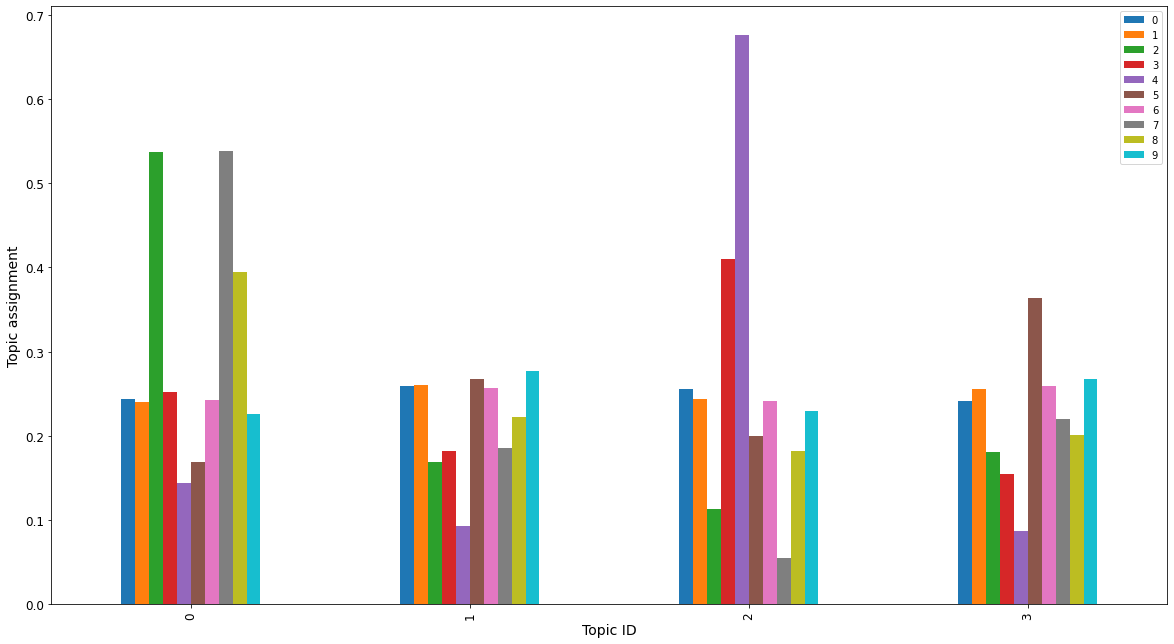

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

fs = 12
df=pd.DataFrame(predictions.T)
df.plot(kind='bar', figsize=(20, 11), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

## Delete endpoint after performing inferences
---

In [106]:
sagemaker.Session().delete_endpoint(ntm_predictor.endpoint_name)

2021-06-26 06:58:28,641 | INFO | session.py:3023 | delete_endpoint | Deleting endpoint with name: ntm-2021-06-26-06-43-05-751


## Load model artifacts stored in output directory
---

In [143]:
model_path = os.path.join(output_prefix, ntm._current_job_name, "output/model.tar.gz")
model_path

'sagemaker/regalado/output/ntm-2021-06-26-07-02-13-771/output/model.tar.gz'

In [144]:
boto3.resource("s3").Bucket(bucket).download_file(model_path, "downloaded_model.tar.gz")

In [145]:
!pwd

/home/ec2-user/SageMaker/my-experiments


In [146]:
tarfile.open('downloaded_model.tar.gz').extractall()

with zipfile.ZipFile('model_algo-1', 'r') as zip_ref:
    zip_ref.extractall('./')
    
model = mx.ndarray.load("params")
W = model["arg:projection_weight"]

## Model exploration
---

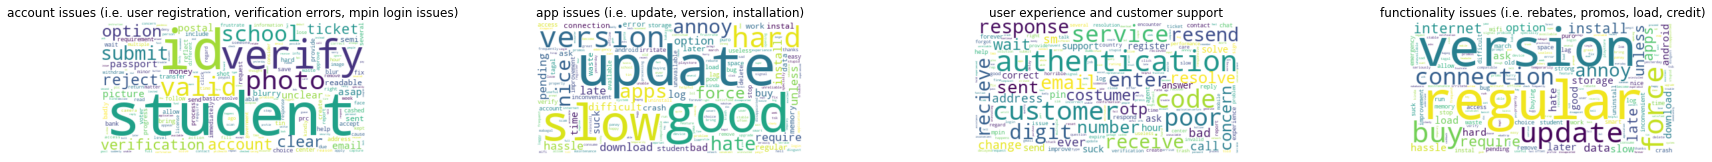

In [153]:
word_to_id = dict()

for i, v in enumerate(vocab_list):
    word_to_id[v] = i

limit = 30
n_col = 4
counter = 0

plt.figure(figsize=(30, 20))

for ind in range(num_topics):

    if counter >= limit:
        break
        
    title_str = topics[ind]
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()
    word_freq = dict()
    
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] = pvals[i]

    wordcloud = wc.WordCloud(background_color="white").fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title_str)

    counter += 1

## 1-star App Store model
---

In [187]:
sesh = sagemaker.Session()

ntm = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.m4.xlarge', # Free-tier instance (Free Tier usage per month for the first 2 months) ~ https://aws.amazon.com/sagemaker/pricing/
    output_path=output_path,
    sagemaker_session=sesh
)

num_topics = 2

ntm.set_hyperparameters(
    num_topics=num_topics, 
    feature_dim=vocab_size, 
    epochs=100, 
    num_patience_epochs=5, 
    batch_norm=True,
    encoder_layers_activation='sigmoid',
    learning_rate=0.014170,
    mini_batch_size=1632,
    optimizer='adadelta',
    rescale_gradient=0.196223,
    weight_decay=0.514082
)

In [188]:
print(f'vocab size = {vocab_size}')
print(f'topic count = {num_topics}')
print(f'\nplatform: {main_df.type.values[0]}\nrating: {main_df.rating.values[0]}')

vocab size = 40
topic count = 2

platform: app store
rating: 1


In [189]:
# WETC - The word embedding topic coherence metric measures the similarity of words in a topic by using a pre-trained word embedding, Glove-6B-400K-50d.
# TU - The topic unicity tells us how unique the word groups per topic are used overall (i.e. Are these meaningful words?)
# Note: A high (closer to 1) TU represents a high topic uniqueness for the topics detected.
# A high WETC value indicates a higher degree of topic coherence. A typical value would be in the range of 0.2 to 0.8

ntm.fit(inputs={"train": s3_train, "validation": s3_valid, "auxiliary": s3_aux_path})

2021-06-26 07:46:54,451 | INFO | image_uris.py:198 | _validate_version_and_set_if_needed | Defaulting to the only supported framework/algorithm version: latest.
2021-06-26 07:46:54,466 | INFO | image_uris.py:224 | _processor | Ignoring unnecessary instance type: None.
2021-06-26 07:46:54,467 | INFO | session.py:570 | train | Creating training-job with name: ntm-2021-06-26-07-46-54-450


2021-06-26 07:46:54 Starting - Starting the training job...
2021-06-26 07:47:17 Starting - Launching requested ML instancesProfilerReport-1624693614: InProgress
.........
2021-06-26 07:48:37 Starting - Preparing the instances for training......
2021-06-26 07:49:39 Downloading - Downloading input data
2021-06-26 07:49:39 Training - Downloading the training image...
2021-06-26 07:50:24 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[06/26/2021 07:50:26 INFO 139976987535168] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'encoder_layers': 'a

## Deploy endpoint
---

In [190]:
ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge', wait=False)

2021-06-26 07:51:25,304 | INFO | session.py:2552 | create_model | Creating model with name: ntm-2021-06-26-07-51-25-243
2021-06-26 07:51:25,855 | INFO | session.py:2973 | create_endpoint | Creating endpoint with name ntm-2021-06-26-07-51-25-243


## Perform sample inferences
---

In [202]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

count = 5

# 5-star App Store topics
# topics = ['positive user experience', 'prominent features'] 
# 1-star App Store topics
topics = ['account issues (i.e. user registration, verification errors, mpin login issues)', 'app crashes, customer support, transaction errors'] 
# 1-star Play Store
# topics = ['account issues (i.e. user registration, verification errors, mpin login issues)', \
#           'app issues (i.e. update, version, installation)', 'user experience and customer support', 'functionality issues (i.e. rebates, promos, load, credit)']
# 5-star Play Store
# topics = ['good user experience', 'good user experience', 'good user experience', \
#          'good user experience', 'good user experience', 'noteworthy features', 'good user experience']

predictor_2 = sagemaker.predictor.Predictor(
    endpoint_name=ntm_predictor.endpoint_name, 
    sagemaker_session=sesh, 
    serializer=CSVSerializer(), 
    deserializer=JSONDeserializer()
)

# predictor.update_endpoint()

results = predictor_2.predict(test_vectors[:count])
print(f'Raw prediction/s:\n{results}')

predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(f'\nPredicted topic weights:\n{predictions}\n\nSorted topic assignment scores per input document:')

for i in results['predictions']:
    sorted_indexes = np.argsort(i['topic_weights']).tolist()
    sorted_indexes.reverse()
    top_topics = [topics[j] for j in sorted_indexes]
    top_weights = [i['topic_weights'][j] for j in sorted_indexes]
    pairs = list(zip(top_topics, top_weights))
    print(pairs)

Raw prediction/s:
{'predictions': [{'topic_weights': [0.4852165282, 0.5147835016]}, {'topic_weights': [0.4852165282, 0.5147835016]}, {'topic_weights': [0.4852165282, 0.5147835016]}, {'topic_weights': [0.4852165282, 0.5147835016]}, {'topic_weights': [0.4852165282, 0.5147835016]}]}

Predicted topic weights:
[[0.48521653 0.5147835 ]
 [0.48521653 0.5147835 ]
 [0.48521653 0.5147835 ]
 [0.48521653 0.5147835 ]
 [0.48521653 0.5147835 ]]

Sorted topic assignment scores per input document:
[('app crashes, customer support, transaction errors', 0.5147835016), ('account issues (i.e. user registration, verification errors, mpin login issues)', 0.4852165282)]
[('app crashes, customer support, transaction errors', 0.5147835016), ('account issues (i.e. user registration, verification errors, mpin login issues)', 0.4852165282)]
[('app crashes, customer support, transaction errors', 0.5147835016), ('account issues (i.e. user registration, verification errors, mpin login issues)', 0.4852165282)]
[('app c

In [192]:
print(f'\noriginal text:')
for i in range(count):
    print(f'\n{[i]} - {test_data.review.values.tolist()[i]}')


original text:

[0] - I thought this would be a convenient app, but as for starters, beginners or just new to this app, it will completely waste your time. Tried to verify my account, app says for only 5 mins but it made me set it up for 30 because it keeps on denying my ID’s and info! Now I’m trying to verify my e-mail and they keep on popping out “Invalid Request”, when I am inputting the code that they sent to me which is 4 minutes late before you’ll receive it. Seriously its been almost 2 hours when I started setting up things into you application. This is beyond inconvenience and doesn’t help at all.

[1] - One of the problems I’ve encountered was paying my electric bill. The app keeps saying my account number is invalid but it isn’t, okay? I T  I S N ‘ T!!!!

[2] - Bring back the gaming credit!!

[3] - You have received P7742.00 of GCash from 7eleven Kiosk with MSG - 2110-3423-3349. A 2% service fee amounting to P158.00 has been deducted from your wallet for reaching the P8000.0

In [193]:
test_counts = pd.DataFrame(
    test_vectors[:count],
    columns=vocab_list
)

print(display(test_counts))

,account,amount,ask,bad,bank,bill,card,cash,code,crash,customer,email,error,fix,help,issue,load,log,money,number,option,pay,pera,problem,receive,send,sent,service,student,submit,support,ticket,time,transaction,transfer,update,verification,verify,wait,work
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


None


## Delete endpoint after performing inferences
---

In [91]:
sagemaker.Session().delete_endpoint(ntm_predictor.endpoint_name)

2021-06-25 03:07:30,966 | INFO | session.py:3023 | delete_endpoint | Deleting endpoint with name: ntm-2021-06-25-02-54-01-157


Text(0.5, 0, 'Topic ID')

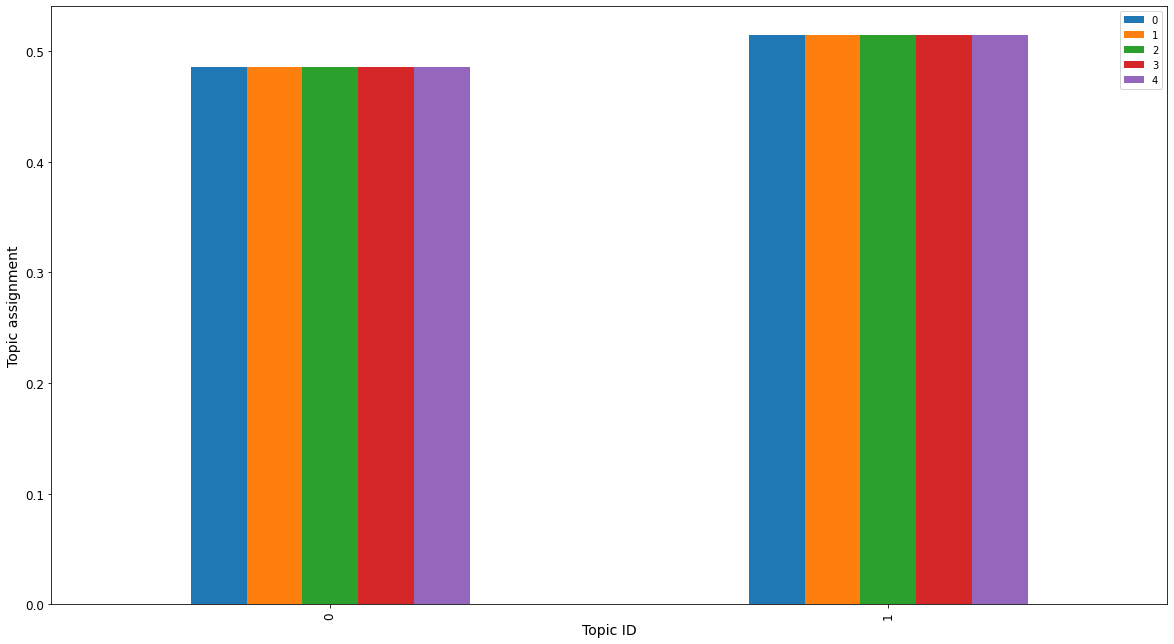

In [203]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

fs = 12
df=pd.DataFrame(predictions.T)
df.plot(kind='bar', figsize=(20, 11), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

## Load model artifacts stored in output directory
---

In [195]:
model_path = os.path.join(output_prefix, ntm._current_job_name, "output/model.tar.gz")
model_path

'sagemaker/regalado/output/ntm-2021-06-26-07-46-54-450/output/model.tar.gz'

In [196]:
boto3.resource("s3").Bucket(bucket).download_file(model_path, "downloaded_model.tar.gz")

In [197]:
!pwd

/home/ec2-user/SageMaker/my-experiments


In [198]:
tarfile.open('downloaded_model.tar.gz').extractall()

with zipfile.ZipFile('model_algo-1', 'r') as zip_ref:
    zip_ref.extractall('./')
    
model = mx.ndarray.load("params")
W = model["arg:projection_weight"]

## Model exploration
---

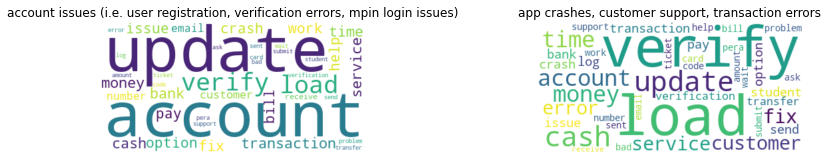

In [199]:
word_to_id = dict()

for i, v in enumerate(vocab_list):
    word_to_id[v] = i

limit = 30
n_col = 4
counter = 0

plt.figure(figsize=(30, 20))

for ind in range(num_topics):

    if counter >= limit:
        break
        
    title_str = topics[ind]
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()
    word_freq = dict()
    
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] = pvals[i]

    wordcloud = wc.WordCloud(background_color="white").fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title_str)

    counter += 1

## 5-star Play Store model
---

In [330]:
sesh = sagemaker.Session()

ntm = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.m4.xlarge', # Free-tier instance (Free Tier usage per month for the first 2 months) ~ https://aws.amazon.com/sagemaker/pricing/
    output_path=output_path,
    sagemaker_session=sesh
)

num_topics = 2

ntm.set_hyperparameters(
    num_topics=num_topics, 
    feature_dim=vocab_size, 
    epochs=100, 
    num_patience_epochs=5, 
    batch_norm=True,
    encoder_layers_activation='relu',
    learning_rate=0.000122,
    mini_batch_size=254,
    optimizer='adadelta',
    rescale_gradient=0.225654,
    weight_decay=0.661741
)

In [331]:
print(f'vocab size = {vocab_size}')
print(f'topic count = {num_topics}')
print(f'\nplatform: {main_df.type.values[0]}\nrating: {main_df.rating.values[0]}')

vocab size = 1000
topic count = 2

platform: play store
rating: 5


In [332]:
# WETC - The word embedding topic coherence metric measures the similarity of words in a topic by using a pre-trained word embedding, Glove-6B-400K-50d.
# TU - The topic unicity tells us how unique the word groups per topic are used overall (i.e. Are these meaningful words?)
# Note: A high (closer to 1) TU represents a high topic uniqueness for the topics detected.
# A high WETC value indicates a higher degree of topic coherence. A typical value would be in the range of 0.2 to 0.8

ntm.fit(inputs={"train": s3_train, "validation": s3_valid, "auxiliary": s3_aux_path})

2021-06-26 10:03:23,545 | INFO | image_uris.py:198 | _validate_version_and_set_if_needed | Defaulting to the only supported framework/algorithm version: latest.
2021-06-26 10:03:23,555 | INFO | image_uris.py:224 | _processor | Ignoring unnecessary instance type: None.
2021-06-26 10:03:23,557 | INFO | session.py:570 | train | Creating training-job with name: ntm-2021-06-26-10-03-23-544


2021-06-26 10:03:23 Starting - Starting the training job...
2021-06-26 10:03:47 Starting - Launching requested ML instancesProfilerReport-1624701803: InProgress
......
2021-06-26 10:04:47 Starting - Preparing the instances for training.........
2021-06-26 10:06:22 Downloading - Downloading input data
2021-06-26 10:06:22 Training - Downloading the training image....Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[06/26/2021 10:06:59 INFO 139728131139392] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'encoder_layers': 'auto', 'mini_batch_size': '256', 'epochs': '50', 'encoder_layers_activation': 'sigmoid', 

## Deploy endpoint
---

In [333]:
ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge', wait=False)

2021-06-26 10:09:44,473 | INFO | session.py:2552 | create_model | Creating model with name: ntm-2021-06-26-10-09-44-420
2021-06-26 10:09:45,024 | INFO | session.py:2973 | create_endpoint | Creating endpoint with name ntm-2021-06-26-10-09-44-420


## Perform sample inferences
---

In [334]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

count = 5

# 5-star App Store topics
# topics = ['positive user experience', 'prominent features'] 
# 1-star App Store topics
# topics = ['account issues (i.e. user registration, verification errors, mpin login issues)', 'app crashes, customer support, transaction errors'] 
# 1-star Play Store
# topics = ['account issues (i.e. user registration, verification errors, mpin login issues)', \
#           'app issues (i.e. update, version, installation)', 'user experience and customer support', 'functionality issues (i.e. rebates, promos, load, credit)']
# 5-star Play Store
topics = ['good user experience', 'good user experience']
          
predictor_2 = sagemaker.predictor.Predictor(
    endpoint_name=ntm_predictor.endpoint_name, 
    sagemaker_session=sesh, 
    serializer=CSVSerializer(), 
    deserializer=JSONDeserializer()
)

# predictor.update_endpoint()

results = predictor_2.predict(test_vectors[:count])
print(f'Raw prediction/s:\n{results}')

predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(f'\nPredicted topic weights:\n{predictions}\n\nSorted topic assignment scores per input document:')

for i in results['predictions']:
    sorted_indexes = np.argsort(i['topic_weights']).tolist()
    sorted_indexes.reverse()
    top_topics = [topics[j] for j in sorted_indexes]
    top_weights = [i['topic_weights'][j] for j in sorted_indexes]
    pairs = list(zip(top_topics, top_weights))
    print(pairs)

Raw prediction/s:
{'predictions': [{'topic_weights': [0.4996371865, 0.5003628135]}, {'topic_weights': [0.4996371865, 0.5003628135]}, {'topic_weights': [0.4996371865, 0.5003628135]}, {'topic_weights': [0.4996371865, 0.5003628135]}, {'topic_weights': [0.4996371865, 0.5003628135]}]}

Predicted topic weights:
[[0.49963719 0.50036281]
 [0.49963719 0.50036281]
 [0.49963719 0.50036281]
 [0.49963719 0.50036281]
 [0.49963719 0.50036281]]

Sorted topic assignment scores per input document:
[('good user experience', 0.5003628135), ('good user experience', 0.4996371865)]
[('good user experience', 0.5003628135), ('good user experience', 0.4996371865)]
[('good user experience', 0.5003628135), ('good user experience', 0.4996371865)]
[('good user experience', 0.5003628135), ('good user experience', 0.4996371865)]
[('good user experience', 0.5003628135), ('good user experience', 0.4996371865)]


In [335]:
print(f'\noriginal text:')
for i in range(count):
    print(f'\n{[i]} - {test_data.review.values.tolist()[i]}')


original text:

[0] - Good

[1] - Its good Apps

[2] - Nice I like it

[3] - Alright

[4] - Nice!


In [336]:
test_counts = pd.DataFrame(
    test_vectors[:count],
    columns=vocab_list
)

print(display(test_counts))

,able,abroad,absolutely,accept,accesible,access,accessable,accessible,accnt,accommodate,accomodating,account,accurate,acount,action,active,actually,additional,address,advance,affordable,age,agent,ago,akala,akong,alam,allow,allowance,alot,alright,although,amaze,among,amount,amzing,anak,android,annoy,anong,answer,anu,anyone,anytime,anyway,anywhere,apk,aplication,apo,app.very,appear,application,apply,appp,appreciate,approve,apps,april,aps,apss,area,around,asap,aside,ask,assist,assistance,atm,authentication,automatically,avail,available,avoid,away,awesome,awesomeness,awit,awsome,ayaw,ayos,ayuda,ayus,ayusin,bad,badly,bagal,bagay,bahay,baka,balance,bank,banking,base,basta,bat,bawas,bayad,bayaran,bcoz,bdo,beautiful,become,believe,beneficial,benefit,berry,best,big,bigyan,bilis,bill,billing,bit,bkit,bla,blah,bless,bought,bpi,bravo,brilliant,bring,budget,bug,buhay,business,bussiness,busy,buy,buying,buyload,buzzbreak,call,camera,card,care,case,cash,cash-in,cashback,cashin,cashless,cashout,cause,cellphone,center,change,charge,chat,check,choice,christmas,cia,cignal,cimb,claim,clear,click,code,coin,coins.ph,comfortable,comment,company,compare,complain,complete,comportable,concern,confirmation,connect,connection,consider,contact,content,continue,convenience,convenient,conveniently,convert,convience,convienient,convient,convince,convinience,convinient,cool,correct,costumer,country,course,covid,crash,create,creator,credit,crisis,crypto,cryptocurrency,currency,customer,cute,cuz,cya,daily,dali,daling,dami,data,date,dati,deal,debit,deduct,deduction,definitely,delay,delete,dependable,deposit,deserve,detail,developer,diamond,different,difficult,difficulty,digit,digital,diko,dina,directly,dis,disappointed,discount,download,dto,due,duper,earn,ease,easily,easy,easy-to-use,ecq,edit,effecient,effective,efficient,effort,...,reason,rebate,receive,recharge,recieve,recieved,recomended,recommend,recommendable,recover,refer,referral,reflect,refund,regard,register,regular,reinstall,relative,reliable,reload,remember,remitance,remittance,remove,reply,request,require,requirement,resolve,respond,response,responsive,retrieve,return,review,reward,right,rin,robux,run,sad,safe,safer,safety,saken,sakin,salamat,san,sap,satisfaction,satisfactory,satisfied,satisfy,save,saver,saving,sayang,sayo,scam,scammer,scan,school,score,second,secure,security,self,sell,seller,send,sent,serbisyo,serve,service,settle,share,shop,shopee,shopping,sign,signal,sim,simcard,simple,simply,sister,situation,siyang,skin,slow,small,smart,smooth,sna,sobra,sobrang,solid,solution,solve,someone,sometime,soo,soooo,sorry,specially,speed,ss,stable,stay,step,stop,store,student,stuff,submit,subrang,success,successful,successfully,suck,suddenly,suggest,suggestion,sulit,super,superb,support,sure,syang,system,ta,tagal,talaga,tangina,tao,tap,tell,term,text,thankful,thankfull,thankfully,thanks,thankyou,thankz,thise,thnks,tho,thumb,thump,ticket,time,timely,tin,tlaga,tlga,tnx,tong,top,totally,tranfer,transact,transaction,transfer,transper,travel,tree,trip,trouble,tru,truly,trust,trustworthy,tulong,two,txt,type,ulit,unable,unavailable,understand,uninstall,union,unique,unlock,unsuccessful,update,upgrade,upon,ups,us,usable,usage,useable,useful,usefully,useless,user,user-friendly,utang,utility,valid,veey,ver,verification,verify,verrygood,version,verygood,verynice,vgood,view,virus,voucher,vry,wag,wait,wallet,wan,waste,wat,watch,water,week,western,wew,wherein,wherever,wife,wifi,win,withdraw,withdrawal,within,wla,wonder,wonderful,wonderfull,work,world,worry,worth,yan,yawa,yay,yesterday,yey,yong,youtube
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

None


## Delete endpoint after performing inferences
---

In [343]:
sagemaker.Session().delete_endpoint(ntm_predictor.endpoint_name)

2021-06-26 10:19:42,640 | INFO | session.py:3023 | delete_endpoint | Deleting endpoint with name: ntm-2021-06-26-10-09-44-420


Text(0.5, 0, 'Topic ID')

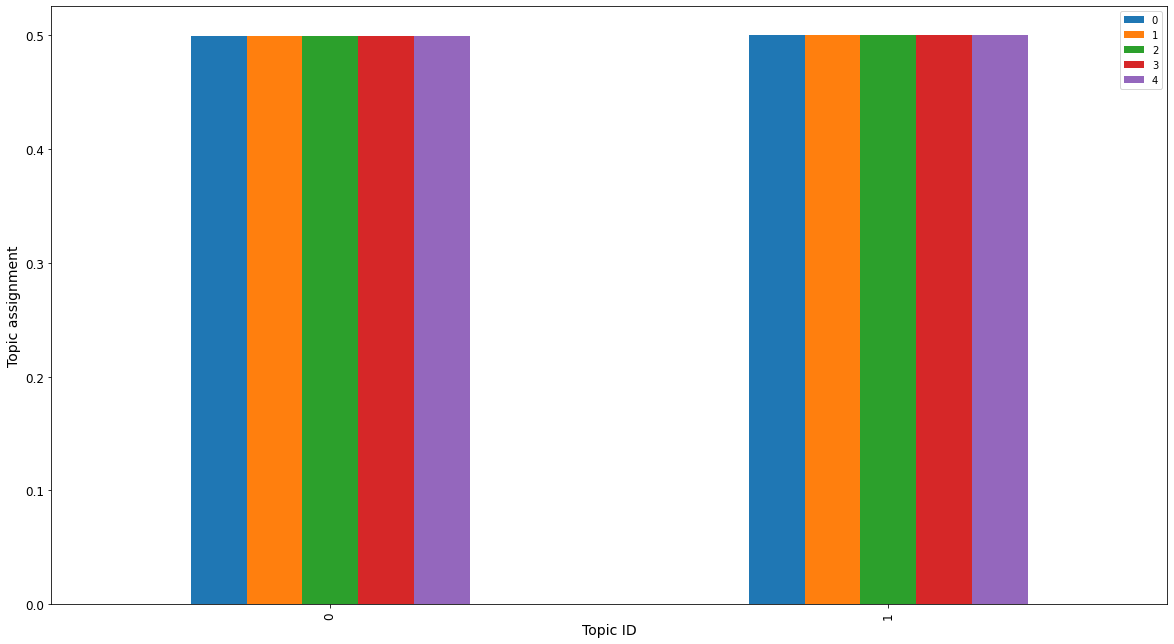

In [337]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

fs = 12
df=pd.DataFrame(predictions.T)
df.plot(kind='bar', figsize=(20, 11), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

## Load model artifacts stored in output directory
---

In [338]:
model_path = os.path.join(output_prefix, ntm._current_job_name, "output/model.tar.gz")
model_path

'sagemaker/regalado/output/ntm-2021-06-26-10-03-23-544/output/model.tar.gz'

In [339]:
boto3.resource("s3").Bucket(bucket).download_file(model_path, "downloaded_model.tar.gz")

In [340]:
!pwd

/home/ec2-user/SageMaker/my-experiments


In [341]:
tarfile.open('downloaded_model.tar.gz').extractall()

with zipfile.ZipFile('model_algo-1', 'r') as zip_ref:
    zip_ref.extractall('./')
    
model = mx.ndarray.load("params")
W = model["arg:projection_weight"]

## Model exploration
---

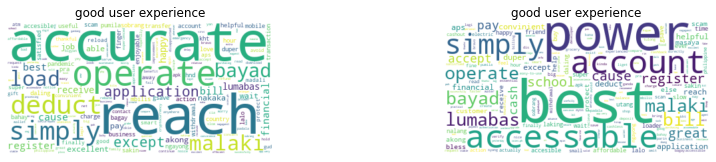

In [342]:
word_to_id = dict()

for i, v in enumerate(vocab_list):
    word_to_id[v] = i

limit = 30
n_col = 4
counter = 0

plt.figure(figsize=(30, 20))

for ind in range(num_topics):

    if counter >= limit:
        break
        
    title_str = topics[ind]
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()
    word_freq = dict()
    
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] = pvals[i]

    wordcloud = wc.WordCloud(background_color="white").fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title_str)

    counter += 1

## 5-star App Store model
---

In [383]:
sesh = sagemaker.Session()

ntm = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.m4.xlarge', # Free-tier instance (Free Tier usage per month for the first 2 months) ~ https://aws.amazon.com/sagemaker/pricing/
    output_path=output_path,
    sagemaker_session=sesh
)

num_topics = 2

ntm.set_hyperparameters(
    num_topics=num_topics, 
    feature_dim=vocab_size, 
    epochs=100, 
    num_patience_epochs=5, 
    batch_norm=True,
    encoder_layers_activation='sigmoid',
    learning_rate=0.005770,
    mini_batch_size=2048,
    optimizer='adam',
    rescale_gradient=0.273173,
    weight_decay=0.684742
)

In [384]:
print(f'vocab size = {vocab_size}')
print(f'topic count = {num_topics}')
print(f'\nplatform: {main_df.type.values[0]}\nrating: {main_df.rating.values[0]}')

vocab size = 60
topic count = 2

platform: app store
rating: 5


In [385]:
# WETC - The word embedding topic coherence metric measures the similarity of words in a topic by using a pre-trained word embedding, Glove-6B-400K-50d.
# TU - The topic unicity tells us how unique the word groups per topic are used overall (i.e. Are these meaningful words?)
# Note: A high (closer to 1) TU represents a high topic uniqueness for the topics detected.
# A high WETC value indicates a higher degree of topic coherence. A typical value would be in the range of 0.2 to 0.8

ntm.fit(inputs={"train": s3_train, "validation": s3_valid, "auxiliary": s3_aux_path})

2021-06-26 11:05:04,288 | INFO | image_uris.py:198 | _validate_version_and_set_if_needed | Defaulting to the only supported framework/algorithm version: latest.
2021-06-26 11:05:04,300 | INFO | image_uris.py:224 | _processor | Ignoring unnecessary instance type: None.
2021-06-26 11:05:04,301 | INFO | session.py:570 | train | Creating training-job with name: ntm-2021-06-26-11-05-04-287


2021-06-26 11:05:04 Starting - Starting the training job...
2021-06-26 11:05:28 Starting - Launching requested ML instancesProfilerReport-1624705504: InProgress
.........
2021-06-26 11:06:48 Starting - Preparing the instances for training......
2021-06-26 11:07:55 Downloading - Downloading input data...
2021-06-26 11:08:29 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[06/26/2021 11:08:45 INFO 140071306274624] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'encoder_layers': 'auto', 'mini_batch_size': '256', 'epochs': '50', 'encoder_layers_activation': 'sigmoid',

## Deploy endpoint
---

In [386]:
ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge', wait=False)

2021-06-26 11:10:34,200 | INFO | session.py:2552 | create_model | Creating model with name: ntm-2021-06-26-11-10-34-142
2021-06-26 11:10:34,786 | INFO | session.py:2973 | create_endpoint | Creating endpoint with name ntm-2021-06-26-11-10-34-142


## Perform sample inferences
---

In [398]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

count = 5

# 5-star App Store topics
topics = ['maintenance requests and general inquiries', 'positive user experience'] 
# 1-star App Store topics
# topics = ['account issues (i.e. user registration, verification errors, mpin login issues)', 'app crashes, customer support, transaction errors'] 
# 1-star Play Store
# topics = ['account issues (i.e. user registration, verification errors, mpin login issues)', \
#           'app issues (i.e. update, version, installation)', 'user experience and customer support', 'functionality issues (i.e. rebates, promos, load, credit)']
# 5-star Play Store
# topics = ['good user experience', 'good user experience']
          
predictor_2 = sagemaker.predictor.Predictor(
    endpoint_name=ntm_predictor.endpoint_name, 
    sagemaker_session=sesh, 
    serializer=CSVSerializer(), 
    deserializer=JSONDeserializer()
)

# predictor.update_endpoint()

results = predictor_2.predict(test_vectors[:count])
print(f'Raw prediction/s:\n{results}')

predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(f'\nPredicted topic weights:\n{predictions}\n\nSorted topic assignment scores per input document:')

for i in results['predictions']:
    sorted_indexes = np.argsort(i['topic_weights']).tolist()
    sorted_indexes.reverse()
    top_topics = [topics[j] for j in sorted_indexes]
    top_weights = [i['topic_weights'][j] for j in sorted_indexes]
    pairs = list(zip(top_topics, top_weights))
    print(pairs)

Raw prediction/s:
{'predictions': [{'topic_weights': [0.4945318699, 0.5054680705]}, {'topic_weights': [0.4945321679, 0.5054678321]}, {'topic_weights': [0.494535476, 0.5054645538]}, {'topic_weights': [0.4945416152, 0.5054583549]}, {'topic_weights': [0.4945326746, 0.5054673553]}]}

Predicted topic weights:
[[0.49453187 0.50546807]
 [0.49453217 0.50546783]
 [0.49453548 0.50546455]
 [0.49454162 0.50545835]
 [0.49453267 0.50546736]]

Sorted topic assignment scores per input document:
[('positive user experience', 0.5054680705), ('maintenance requests and general inquiries', 0.4945318699)]
[('positive user experience', 0.5054678321), ('maintenance requests and general inquiries', 0.4945321679)]
[('positive user experience', 0.5054645538), ('maintenance requests and general inquiries', 0.494535476)]
[('positive user experience', 0.5054583549), ('maintenance requests and general inquiries', 0.4945416152)]
[('positive user experience', 0.5054673553), ('maintenance requests and general inquiries

In [399]:
print(f'\noriginal text:')
for i in range(count):
    print(f'\n{[i]} - {test_data.review.values.tolist()[i]}')


original text:

[0] - Hi GCash ask ko lang po if pano marerecover yung ATM ko kahit wala na po yung dati kong number? Really need lang po please answer.

[1] - During the lockdown i thought i wouldnt be able to get my money that was sent by mistake to a wrong number, i just sent an email since i know contact call centers does not have full workforce so i will not be able to go through, true enough few emails sent and I got my money back

[2] - From money transfer to savings to investing.

[3] - I love the convenience the app gives. I just wish the developers would create like a running meter or something that would visiually show how much you’re on the daily and monthly limits. Since I use this app a lot, that would be a great enhancement

[4] - Payments, money transfers, savings, credit, insurance... it has everything I would normally need a bank or credit card for.

I've pretty much stopped using my credit card and other online banking services since I got on GCash.


In [400]:
test_counts = pd.DataFrame(
    test_vectors[:count],
    columns=vocab_list
)

print(display(test_counts))

,able,access,account,apps,available,bank,best,bill,buy,call,card,cash,contact,convenience,convenient,customer,data,date,different,easy,encounter,error,fast,fee,fix,fund,good,great,help,invest,issue,load,love,mastercard,money,number,online,pandemic,pay,payment,peso,problem,rebate,return,review,save,saving,send,service,thanks,time,transaction,transfer,update,useful,user,verify,version,wait,wallet
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


None


## Delete endpoint after performing inferences
---

In [408]:
sagemaker.Session().delete_endpoint(ntm_predictor.endpoint_name)

2021-06-26 11:22:32,674 | INFO | session.py:3023 | delete_endpoint | Deleting endpoint with name: ntm-2021-06-26-11-10-34-142


Text(0.5, 0, 'Topic ID')

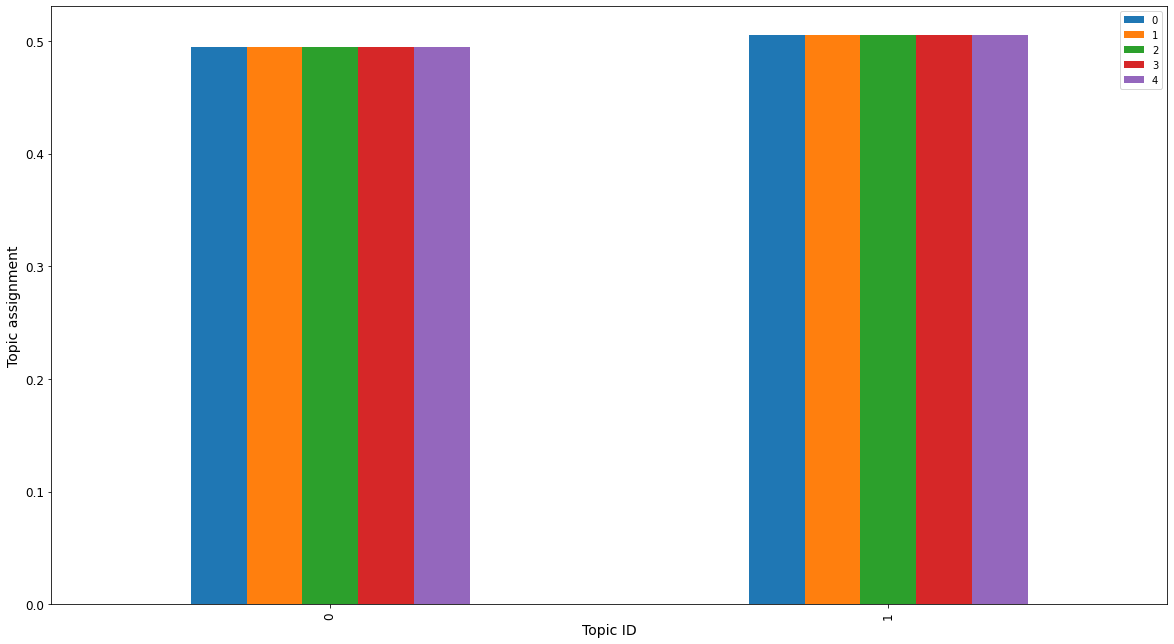

In [390]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

fs = 12
df=pd.DataFrame(predictions.T)
df.plot(kind='bar', figsize=(20, 11), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

## Load model artifacts stored in output directory
---

In [401]:
model_path = os.path.join(output_prefix, ntm._current_job_name, "output/model.tar.gz")
model_path

'sagemaker/regalado/output/ntm-2021-06-26-11-05-04-287/output/model.tar.gz'

In [402]:
boto3.resource("s3").Bucket(bucket).download_file(model_path, "downloaded_model.tar.gz")

In [403]:
!pwd

/home/ec2-user/SageMaker/my-experiments


In [404]:
tarfile.open('downloaded_model.tar.gz').extractall()

with zipfile.ZipFile('model_algo-1', 'r') as zip_ref:
    zip_ref.extractall('./')
    
model = mx.ndarray.load("params")
W = model["arg:projection_weight"]

## Model exploration
---

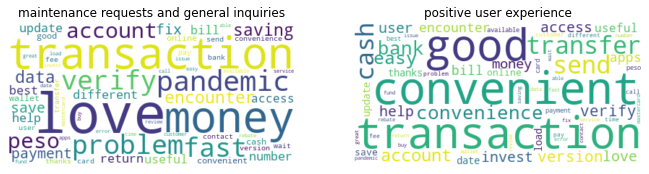

In [407]:
word_to_id = dict()

for i, v in enumerate(vocab_list):
    word_to_id[v] = i

limit = 30
n_col = 5
counter = 0

plt.figure(figsize=(30, 20))

for ind in range(num_topics):

    if counter >= limit:
        break
        
    title_str = topics[ind]
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()
    word_freq = dict()
    
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] = pvals[i]

    wordcloud = wc.WordCloud(background_color="white").fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title_str)

    counter += 1